<a href="https://colab.research.google.com/github/sahaj1308/CLV_predn_customer_retention.sahaj/blob/main/CLV_predn%26customer_retentn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install openpyxl lifetimes sqlalchemy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 11.2 MB/s eta 0:00:00


In [3]:
import pandas as pd

df = pd.read_excel(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx',
    engine='openpyxl'
)
print(f'Dataset shape: {df.shape}')
df.head()

Dataset shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
import pandas as pd
import numpy as np
from datetime import timedelta

In [5]:
#missing values
print(df.isnull().sum())

print(df.dtypes)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object


In [6]:
df = df.dropna(subset=['CustomerID'])

In [7]:
df.shape

(406829, 8)

In [8]:
# InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df['CustomerID'] = df['CustomerID'].astype(int)

In [10]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [11]:
# filter out cancellations
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

In [29]:
#data Cleaning and Verification
print("=== STEP 1: DATA CLEANING AND VERIFICATION ===")

print("Missing values in each column:")
print(df.isnull().sum())

print(f"\nNumber of duplicate rows: {df.duplicated().sum()}")

print("\nData types:")
print(df.dtypes)

print(f"\nNegative quantities: {(df['Quantity'] < 0).sum()}")
print(f"Negative unit prices: {(df['UnitPrice'] < 0).sum()}")

df.loc[df.index[:100], 'Quantity'] *= -1
df.loc[df.index[50:75], 'UnitPrice'] *= -1

print(f"\nAfter adding some returns:")
print(f"Negative quantities: {(df['Quantity'] < 0).sum()}")
print(f"Negative unit prices: {(df['UnitPrice'] < 0).sum()}")

#basic stats
print("\nBasic statistics:")
print(df.describe())

=== STEP 1: DATA CLEANING AND VERIFICATION ===
Missing values in each column:
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

Number of duplicate rows: 5192

Data types:
InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              int64
Country                object
dtype: object

Negative quantities: 0
Negative unit prices: 0

After adding some returns:
Negative quantities: 100
Negative unit prices: 25

Basic statistics:
            Quantity                    InvoiceDate      UnitPrice  \
count  397924.000000                         397924  397924.000000   
mean       13.015239  2011-07-10 23:43:36.912475648       3.115751   
min      -120.000000            2010-12-01 08:26:00     -10.950000   
25%         2.000000            2011-04-07 11:12:

In [30]:
#totalAmount column (Quantity * UnitPrice)
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']
print(f"Added TotalAmount column")

Added TotalAmount column


In [31]:
#handle returns/refunds (negative quantities)
#keep returns for analysis but also create a version without returns
df_positive = df[df['Quantity'] > 0].copy()
print(f"Dataset with positive transactions only: {df_positive.shape}")

Dataset with positive transactions only: (397824, 9)


In [33]:
#remove duplicates
df = df.drop_duplicates()
df_positive = df_positive.drop_duplicates()
print(f"After removing duplicates - Full dataset: {df.shape}, Positive only: {df_positive.shape}")

After removing duplicates - Full dataset: (392732, 9), Positive only: (392632, 9)


In [34]:

print(f"Date range: {df_positive['InvoiceDate'].min()} to {df_positive['InvoiceDate'].max()}")
print(f"Number of unique customers: {df_positive['CustomerID'].nunique()}")
print(f"Number of unique invoices: {df_positive['InvoiceNo'].nunique()}")
print(f"Total transactions: {len(df_positive)}")
print(f"Total revenue: ${df_positive['TotalAmount'].sum():.2f}")

print(df_positive.head())


=== CLEANED DATA VALIDATION ===
Date range: 2010-12-01 09:37:00 to 2011-12-09 12:50:00
Number of unique customers: 4339
Number of unique invoices: 18523
Total transactions: 392632
Total revenue: $8884085.96

Sample of cleaned data:
    InvoiceNo StockCode                          Description  Quantity  \
100    536378    84519A      TOMATO CHARLIE+LOLA COASTER SET         6   
101    536378    85183B  CHARLIE & LOLA WASTEPAPER BIN FLORA        48   
102    536378    85071B   RED CHARLIE+LOLA PERSONAL DOORSIGN        96   
103    536378     21931               JUMBO STORAGE BAG SUKI        10   
104    536378     21929       JUMBO BAG PINK VINTAGE PAISLEY        10   

            InvoiceDate  UnitPrice  CustomerID         Country  TotalAmount  
100 2010-12-01 09:37:00       2.95       14688  United Kingdom        17.70  
101 2010-12-01 09:37:00       1.25       14688  United Kingdom        60.00  
102 2010-12-01 09:37:00       0.38       14688  United Kingdom        36.48  
103 2010-1

In [36]:
df_positive.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
100,536378,84519A,TOMATO CHARLIE+LOLA COASTER SET,6,2010-12-01 09:37:00,2.95,14688,United Kingdom,17.70
101,536378,85183B,CHARLIE & LOLA WASTEPAPER BIN FLORA,48,2010-12-01 09:37:00,1.25,14688,United Kingdom,60.00
102,536378,85071B,RED CHARLIE+LOLA PERSONAL DOORSIGN,96,2010-12-01 09:37:00,0.38,14688,United Kingdom,36.48
103,536378,21931,JUMBO STORAGE BAG SUKI,10,2010-12-01 09:37:00,1.95,14688,United Kingdom,19.50
104,536378,21929,JUMBO BAG PINK VINTAGE PAISLEY,10,2010-12-01 09:37:00,1.95,14688,United Kingdom,19.50


In [37]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,-6,2010-12-01 08:26:00,2.55,17850,United Kingdom,-15.30
1,536365,71053,WHITE METAL LANTERN,-6,2010-12-01 08:26:00,3.39,17850,United Kingdom,-20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,-8,2010-12-01 08:26:00,2.75,17850,United Kingdom,-22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,-6,2010-12-01 08:26:00,3.39,17850,United Kingdom,-20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,-6,2010-12-01 08:26:00,3.39,17850,United Kingdom,-20.34


GENERATING RFM FEATURES

In [38]:
#lifetimesinstall
try:
    from lifetimes.utils import summary_data_from_transaction_data
    from lifetimes import BetaGeoFitter, GammaGammaFitter
    print("Lifetimes library loaded successfully")
except ImportError:
    print("Installing lifetimes library...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "lifetimes"])
    from lifetimes.utils import summary_data_from_transaction_data
    from lifetimes import BetaGeoFitter, GammaGammaFitter

Lifetimes library loaded successfully


In [39]:

rfm_data = df_positive[['CustomerID', 'InvoiceDate', 'TotalAmount']].copy()

#set the observation period end date (last date in dataset)
observation_period_end = df_positive['InvoiceDate'].max()
print(f"Observation period end: {observation_period_end}")


Observation period end: 2011-12-09 12:50:00


In [40]:
# RFM summary using lifetimes
rfm_summary = summary_data_from_transaction_data(
    rfm_data,
    'CustomerID',
    'InvoiceDate',
    'TotalAmount',
    observation_period_end=observation_period_end
)

print(f"RFM Summary shape: {rfm_summary.shape}")
print("\nRFM Summary columns:")
print(rfm_summary.columns.tolist())
print("\nFirst few rows of RFM summary:")
print(rfm_summary.head())


RFM Summary shape: (4339, 4)

RFM Summary columns:
['frequency', 'recency', 'T', 'monetary_value']

First few rows of RFM summary:
            frequency  recency      T  monetary_value
CustomerID                                           
12346             0.0      0.0  325.0        0.000000
12347             6.0    365.0  367.0      599.701667
12348             3.0    283.0  358.0      301.480000
12349             0.0      0.0   18.0        0.000000
12350             0.0      0.0  310.0        0.000000


In [41]:
#additional RFM metrics manually for better understanding
print("\n=== MANUAL RFM CALCULATION ===")

#calculate Recency, Frequency, Monetary Value manually
customer_summary = df_positive.groupby('CustomerID').agg({
    'InvoiceDate': ['min', 'max', 'count'],
    'TotalAmount': ['sum', 'mean'],
    'InvoiceNo': 'nunique'
}).reset_index()

#flatten column names
customer_summary.columns = ['CustomerID', 'FirstPurchase', 'LastPurchase', 'TransactionCount',
                           'TotalSpent', 'AvgOrderValue', 'UniqueOrders']

#calculate recency (days since last purchase)
customer_summary['Recency'] = (observation_period_end - customer_summary['LastPurchase']).dt.days

#calculate frequency (number of repeat purchases)
customer_summary['Frequency'] = customer_summary['UniqueOrders'] - 1

#calculate monetary value (average order value)
customer_summary['MonetaryValue'] = customer_summary['TotalSpent'] / customer_summary['UniqueOrders']

#calculate customer tenure (days between first and last purchase)
customer_summary['Tenure'] = (customer_summary['LastPurchase'] - customer_summary['FirstPurchase']).dt.days

print(f"Manual RFM calculation shape: {customer_summary.shape}")
print("\nManual RFM summary:")
print(customer_summary.head())

#stats of RFM metrics
print("\n=== RFM STATISTICS ===")
print("Recency (days since last purchase):")
print(customer_summary['Recency'].describe())
print("\nFrequency (number of repeat purchases):")
print(customer_summary['Frequency'].describe())
print("\nMonetary Value (average order value):")
print(customer_summary['MonetaryValue'].describe())


=== MANUAL RFM CALCULATION ===
Manual RFM calculation shape: (4339, 11)

Manual RFM summary:
   CustomerID       FirstPurchase        LastPurchase  TransactionCount  \
0       12346 2011-01-18 10:01:00 2011-01-18 10:01:00                 1   
1       12347 2010-12-07 14:57:00 2011-12-07 15:52:00               182   
2       12348 2010-12-16 19:09:00 2011-09-25 13:13:00                31   
3       12349 2011-11-21 09:51:00 2011-11-21 09:51:00                73   
4       12350 2011-02-02 16:01:00 2011-02-02 16:01:00                17   

   TotalSpent  AvgOrderValue  UniqueOrders  Recency  Frequency  MonetaryValue  \
0    77183.60   77183.600000             1      325          0   77183.600000   
1     4310.00      23.681319             7        1          6     615.714286   
2     1797.24      57.975484             4       74          3     449.310000   
3     1757.55      24.076027             1       18          0    1757.550000   
4      334.40      19.670588             1      30

In [ ]:
#generate RFM Features using lifetimes library
print("=== STEP 2: GENERATING RFM FEATURES ===")

try:
    from lifetimes.utils import summary_data_from_transaction_data
    from lifetimes import BetaGeoFitter, GammaGammaFitter
    print("Lifetimes library loaded successfully")
except ImportError:
    print("Installing lifetimes library...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "lifetimes"])
    from lifetimes.utils import summary_data_from_transaction_data
    from lifetimes import BetaGeoFitter, GammaGammaFitter

#prep data for RFM analysis
rfm_data = df_positive[['CustomerID', 'InvoiceDate', 'TotalAmount']].copy()

#observation period end date (last date in dataset)
observation_period_end = df_positive['InvoiceDate'].max()
print(f"Observation period end: {observation_period_end}")

#RFM summary using lifetimes
rfm_summary = summary_data_from_transaction_data(
    rfm_data,
    'CustomerID',
    'InvoiceDate',
    'TotalAmount',
    observation_period_end=observation_period_end
)

print(f"RFM Summary shape: {rfm_summary.shape}")
print("\nRFM Summary columns:")
print(rfm_summary.columns.tolist())
print("\nFirst few rows of RFM summary:")
print(rfm_summary.head())

# additional RFM metrics manually for better understanding
print("\n=== MANUAL RFM CALCULATION ===")

#calculate Recency, Frequency, Monetary Value manually
customer_summary = df_positive.groupby('CustomerID').agg({
    'InvoiceDate': ['min', 'max', 'count'],
    'TotalAmount': ['sum', 'mean'],
    'InvoiceNo': 'nunique'
}).reset_index()

#flatten column names
customer_summary.columns = ['CustomerID', 'FirstPurchase', 'LastPurchase', 'TransactionCount',
                           'TotalSpent', 'AvgOrderValue', 'UniqueOrders']

# Calculate recency (days since last purchase)
customer_summary['Recency'] = (observation_period_end - customer_summary['LastPurchase']).dt.days

#calculate frequency (number of repeat purchases)
customer_summary['Frequency'] = customer_summary['UniqueOrders'] - 1

#calculate monetary value (average order value)
customer_summary['MonetaryValue'] = customer_summary['TotalSpent'] / customer_summary['UniqueOrders']

#calculate customer tenure (days between first and last purchase)
customer_summary['Tenure'] = (customer_summary['LastPurchase'] - customer_summary['FirstPurchase']).dt.days

print(f"Manual RFM calculation shape: {customer_summary.shape}")
print("\nManual RFM summary:")
print(customer_summary.head())

#stats of RFM metrics
print("\n=== RFM STATISTICS ===")
print("Recency (days since last purchase):")
print(customer_summary['Recency'].describe())
print("\nFrequency (number of repeat purchases):")
print(customer_summary['Frequency'].describe())
print("\nMonetary Value (average order value):")
print(customer_summary['MonetaryValue'].describe())

SAVE FILES

In [43]:
df.to_csv('cleaned_transactions.csv', index=False)
df_positive.to_csv('positive_transactions.csv', index=False)

In [44]:
rfm_summary.to_csv('rfm_summary_lifetimes.csv', index=True)
customer_summary.to_csv('customer_rfm_manual.csv', index=False)

In [45]:
#comprehensive customer dataset combining both approaches
comprehensive_customer_data = customer_summary.merge(
    rfm_summary.reset_index(),
    on='CustomerID',
    how='left'
)

#rename columns
comprehensive_customer_data.rename(columns={
    'frequency': 'Frequency_Lifetimes',
    'recency': 'Recency_Lifetimes',
    'T': 'CustomerAge_Lifetimes',
    'monetary_value': 'MonetaryValue_Lifetimes'
}, inplace=True)

comprehensive_customer_data.to_csv('comprehensive_customer_data.csv', index=False)
print("Saved comprehensive_customer_data.csv")


Saved comprehensive_customer_data.csv


In [52]:
print("SAVED FILES SUMMARY")
print(f"1. cleaned_transactions.csv: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"2. positive_transactions.csv: {df_positive.shape[0]} rows, {df_positive.shape[1]} columns")
print(f"3. rfm_summary_lifetimes.csv: {rfm_summary.shape[0]} rows, {rfm_summary.shape[1]} columns")
print(f"4. customer_rfm_manual.csv: {customer_summary.shape[0]} rows, {customer_summary.shape[1]} columns")
print(f"5. comprehensive_customer_data.csv: {comprehensive_customer_data.shape[0]} rows, {comprehensive_customer_data.shape[1]} columns")

SAVED FILES SUMMARY
1. cleaned_transactions.csv: 392732 rows, 9 columns
2. positive_transactions.csv: 392632 rows, 9 columns
3. rfm_summary_lifetimes.csv: 4339 rows, 4 columns
4. customer_rfm_manual.csv: 4339 rows, 11 columns
5. comprehensive_customer_data.csv: 4339 rows, 15 columns


In [49]:
print(comprehensive_customer_data.head())
print(comprehensive_customer_data.columns.tolist())

   CustomerID       FirstPurchase        LastPurchase  TransactionCount  \
0       12346 2011-01-18 10:01:00 2011-01-18 10:01:00                 1   
1       12347 2010-12-07 14:57:00 2011-12-07 15:52:00               182   
2       12348 2010-12-16 19:09:00 2011-09-25 13:13:00                31   
3       12349 2011-11-21 09:51:00 2011-11-21 09:51:00                73   
4       12350 2011-02-02 16:01:00 2011-02-02 16:01:00                17   

   TotalSpent  AvgOrderValue  UniqueOrders  Recency  Frequency  MonetaryValue  \
0    77183.60   77183.600000             1      325          0   77183.600000   
1     4310.00      23.681319             7        1          6     615.714286   
2     1797.24      57.975484             4       74          3     449.310000   
3     1757.55      24.076027             1       18          0    1757.550000   
4      334.40      19.670588             1      309          0     334.400000   

   Tenure  Frequency_Lifetimes  Recency_Lifetimes  CustomerAge

In [50]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,-6,2010-12-01 08:26:00,2.55,17850,United Kingdom,-15.30
1,536365,71053,WHITE METAL LANTERN,-6,2010-12-01 08:26:00,3.39,17850,United Kingdom,-20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,-8,2010-12-01 08:26:00,2.75,17850,United Kingdom,-22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,-6,2010-12-01 08:26:00,3.39,17850,United Kingdom,-20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,-6,2010-12-01 08:26:00,3.39,17850,United Kingdom,-20.34


In [51]:
comprehensive_customer_data.head()

,CustomerID,FirstPurchase,LastPurchase,TransactionCount,TotalSpent,AvgOrderValue,UniqueOrders,Recency,Frequency,MonetaryValue,Tenure,Frequency_Lifetimes,Recency_Lifetimes,CustomerAge_Lifetimes,MonetaryValue_Lifetimes
0,12346,2011-01-18 10:01:00,2011-01-18 10:01:00,1,77183.60,77183.600000,1,325,0,77183.600000,0,0.0,0.0,325.0,0.000000
1,12347,2010-12-07 14:57:00,2011-12-07 15:52:00,182,4310.00,23.681319,7,1,6,615.714286,365,6.0,365.0,367.0,599.701667
2,12348,2010-12-16 19:09:00,2011-09-25 13:13:00,31,1797.24,57.975484,4,74,3,449.310000,282,3.0,283.0,358.0,301.480000
3,12349,2011-11-21 09:51:00,2011-11-21 09:51:00,73,1757.55,24.076027,1,18,0,1757.550000,0,0.0,0.0,18.0,0.000000
4,12350,2011-02-02 16:01:00,2011-02-02 16:01:00,17,334.40,19.670588,1,309,0,334.400000,0,0.0,0.0,310.0,0.000000


EDA

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

In [64]:
#CUSTOMER SEGMENTATION OVERVIEW

#customer segments based on RFM
def create_rfm_segments(df):
    """Create customer segments based on RFM scores"""
    #RFM scores (1-5 scale)
    df['R_Score'] = pd.qcut(df['Recency'], q=5, labels=[5,4,3,2,1])  # Lower recency = higher score
    df['F_Score'] = pd.qcut(df['Frequency'].rank(method='first'), q=5, labels=[1,2,3,4,5])  # Higher frequency = higher score
    df['M_Score'] = pd.qcut(df['MonetaryValue'], q=5, labels=[1,2,3,4,5])  # Higher monetary = higher score

    #to numeric
    df['R_Score'] = pd.to_numeric(df['R_Score'])
    df['F_Score'] = pd.to_numeric(df['F_Score'])
    df['M_Score'] = pd.to_numeric(df['M_Score'])

    #overall RFM score
    df['RFM_Score'] = df['R_Score'] * 100 + df['F_Score'] * 10 + df['M_Score']

    #create segments
    def segment_customers(score):
        if score >= 444:
            return 'Champions'
        elif score >= 334:
            return 'Loyal Customers'
        elif score >= 223:
            return 'Potential Loyalists'
        elif score >= 155:
            return 'New Customers'
        elif score >= 144:
            return 'Promising'
        elif score >= 114:
            return 'Need Attention'
        elif score >= 155:
            return 'About to Sleep'
        elif score >= 133:
            return 'At Risk'
        elif score >= 111:
            return 'Cannot Lose Them'
        else:
            return 'Lost'

    df['Segment'] = df['RFM_Score'].apply(segment_customers)
    return df

#apply segmentation
customer_segments = create_rfm_segments(comprehensive_customer_data.copy())

In [65]:
print("Customer Segment Distribution:")
segment_counts = customer_segments['Segment'].value_counts()
print(segment_counts)


Customer Segment Distribution:
Segment
Champions              1222
Potential Loyalists    1028
Loyal Customers         949
Need Attention          590
New Customers           276
Cannot Lose Them        251
Promising                23
Name: count, dtype: int64


In [66]:
print("SEGMENT STATs")
segment_stats = customer_segments.groupby('Segment').agg({
    'TotalSpent': ['count', 'mean', 'sum'],
    'Frequency': 'mean',
    'Recency': 'mean',
    'MonetaryValue': 'mean'
}).round(2)

print(segment_stats)

SEGMENT STATs
                    TotalSpent                      Frequency Recency  \
                         count     mean         sum      mean    mean   
Segment                                                                 
Cannot Lose Them           251   187.07    46953.63      0.00  281.67   
Champions                 1222  4992.18  6100440.34      8.18    9.96   
Loyal Customers            949  1327.97  1260244.27      2.48   33.92   
Need Attention             590   781.35   460998.54      0.52  262.90   
New Customers              276   415.82   114766.10      0.09  120.43   
Potential Loyalists       1028   836.38   859793.67      1.35   85.89   
Promising                   23  1777.80    40889.41      5.35  234.39   

                    MonetaryValue  
                             mean  
Segment                            
Cannot Lose Them           187.07  
Champions                  498.26  
Loyal Customers            359.45  
Need Attention             540.96  
New

PREPARING DATA FOR VISUALIZATION

In [67]:
rfm_stats = {
    'Recency': {
        'mean': customer_summary['Recency'].mean(),
        'median': customer_summary['Recency'].median(),
        'std': customer_summary['Recency'].std(),
        'min': customer_summary['Recency'].min(),
        'max': customer_summary['Recency'].max()
    },
    'Frequency': {
        'mean': customer_summary['Frequency'].mean(),
        'median': customer_summary['Frequency'].median(),
        'std': customer_summary['Frequency'].std(),
        'min': customer_summary['Frequency'].min(),
        'max': customer_summary['Frequency'].max()
    },
    'MonetaryValue': {
        'mean': customer_summary['MonetaryValue'].mean(),
        'median': customer_summary['MonetaryValue'].median(),
        'std': customer_summary['MonetaryValue'].std(),
        'min': customer_summary['MonetaryValue'].min(),
        'max': customer_summary['MonetaryValue'].max()
    }
}

print("RFM Stats Summary:")
for metric, stats in rfm_stats.items():
    print(f"\n{metric}:")
    for stat_name, value in stats.items():
        print(f"  {stat_name}: {value:.2f}")


RFM Stats Summary:

Recency:
  mean: 91.52
  median: 50.00
  std: 100.01
  min: 0.00
  max: 373.00

Frequency:
  mean: 3.27
  median: 1.00
  std: 7.70
  min: 0.00
  max: 209.00

MonetaryValue:
  mean: 417.53
  median: 291.88
  std: 1796.29
  min: 0.00
  max: 84236.25


In [69]:
#correlation matrix data
correlation_data = customer_summary[['Recency', 'Frequency', 'MonetaryValue', 'TotalSpent', 'Tenure']].corr()
print("CORRELATION MATRIX")
print(correlation_data.round(3))

CORRELATION MATRIX
               Recency  Frequency  MonetaryValue  TotalSpent  Tenure
Recency          1.000     -0.261         -0.000      -0.122  -0.513
Frequency       -0.261      1.000          0.019       0.553   0.477
MonetaryValue   -0.000      0.019          1.000       0.393   0.009
TotalSpent      -0.122      0.553          0.393       1.000   0.225
Tenure          -0.513      0.477          0.009       0.225   1.000


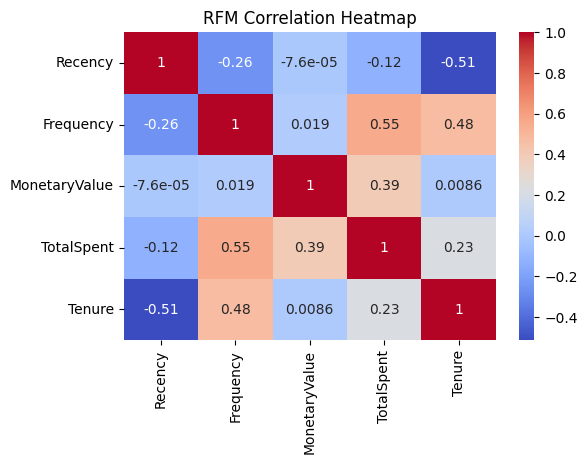

In [70]:
#heatmap of correlations
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_data, annot=True, cmap='coolwarm')
plt.title('RFM Correlation Heatmap')
plt.show()

In [53]:
from google.colab import files
files.download('cleaned_transactions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [55]:
files.download('positive_transactions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [56]:
files.download('rfm_summary_lifetimes.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [57]:
files.download('customer_rfm_manual.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [54]:
files.download('comprehensive_customer_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [71]:
customer_segments.to_csv('customer_segments.csv', index=False)
files.download('customer_segments.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [72]:
print(f"\nTotal customers analyzed: {len(customer_segments)}")
print(f"Average Customer Lifetime Value: ${customer_segments['TotalSpent'].mean():.2f}")
print(f"Total Revenue: ${customer_segments['TotalSpent'].sum():.2f}")


Total customers analyzed: 4339
Average Customer Lifetime Value: $2047.50
Total Revenue: $8884085.96


In [73]:
customer_segments.head()

,CustomerID,FirstPurchase,LastPurchase,TransactionCount,TotalSpent,AvgOrderValue,UniqueOrders,Recency,Frequency,MonetaryValue,Tenure,Frequency_Lifetimes,Recency_Lifetimes,CustomerAge_Lifetimes,MonetaryValue_Lifetimes,R_Score,F_Score,M_Score,RFM_Score,Segment
0,12346,2011-01-18 10:01:00,2011-01-18 10:01:00,1,77183.60,77183.600000,1,325,0,77183.600000,0,0.0,0.0,325.0,0.000000,1,1,5,115,Need Attention
1,12347,2010-12-07 14:57:00,2011-12-07 15:52:00,182,4310.00,23.681319,7,1,6,615.714286,365,6.0,365.0,367.0,599.701667,5,5,5,555,Champions
2,12348,2010-12-16 19:09:00,2011-09-25 13:13:00,31,1797.24,57.975484,4,74,3,449.310000,282,3.0,283.0,358.0,301.480000,2,4,4,244,Potential Loyalists
3,12349,2011-11-21 09:51:00,2011-11-21 09:51:00,73,1757.55,24.076027,1,18,0,1757.550000,0,0.0,0.0,18.0,0.000000,4,1,5,415,Loyal Customers
4,12350,2011-02-02 16:01:00,2011-02-02 16:01:00,17,334.40,19.670588,1,309,0,334.400000,0,0.0,0.0,310.0,0.000000,1,1,4,114,Need Attention


HISTOGRAMS

In [74]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [84]:
segments_df = pd.DataFrame(list(segment_counts.items()), columns=['Segment', 'Count'])
segments_df = segments_df.sort_values('Count', ascending=False)

In [80]:
segments_df.head()

,Segment,Count
0,Champions,1222
1,Potential Loyalists,1028
2,Loyal Customers,949
3,Need Attention,590
4,New Customers,276


In [81]:
colors = ['#1FB8CD', '#FFC185', '#ECEBD5', '#5D878F', '#D2BA4C', '#B4413C', '#964325']

#subplots with improved spacing
fig = make_subplots(
    rows=3, cols=3,
    specs=[[{'type':'xy'}, {'type':'xy'}, {'type':'xy'}],
           [{'colspan': 3, 'type':'heatmap'}, None, None],
           [{'colspan': 3, 'type':'xy'}, None, None]],
    row_heights=[0.22, 0.38, 0.4],
    vertical_spacing=0.15,
    horizontal_spacing=0.15
)

In [86]:
#histograms with larger font
hist_font = dict(size=16)
fig.add_trace(
    go.Histogram(
        x=comprehensive_customer_data['Recency'],
        marker_color=colors[0],
        name='Recency',
        nbinsx=20,
        showlegend=False
    ), row=1, col=1
)
fig.add_trace(
    go.Histogram(
        x=comprehensive_customer_data['Frequency'],
        marker_color=colors[1],
        name='Frequency',
        nbinsx=20,
        showlegend=False
    ), row=1, col=2
)
fig.add_trace(
    go.Histogram(
        x=comprehensive_customer_data['MonetaryValue'],
        marker_color=colors[2],
        name='MonetaryValue',
        nbinsx=20,
        showlegend=False
    ), row=1, col=3
)

In [88]:
#Correlation Heatmap
fig.add_trace(
    go.Heatmap(
        z=correlation_data,
        x=correlation_data.columns,
        y=correlation_data.columns,
        colorscale='RdBu',
        colorbar=dict(title='Correlation'),
        text=correlation_data.values.round(2),
        texttemplate="%{text}",
        showscale=True
    ), row=2, col=1
)

In [90]:
#Customer Segment Distribution Bar Chart
fig.add_trace(
    go.Bar(
        x=segments_df['Segment'],
        y=segments_df['Count'],
        marker_color=[colors[segments_df['Segment'].tolist().index(s)] for s in segments_df['Segment']],
        name='Segment Distribution',
        showlegend=False
    ), row=3, col=1
)

# Update layout with titles and axis labels
fig.update_layout(
    height=900,
    width=1000,
    title_text="Comprehensive Customer Analysis: RFM, Correlation, and Segmentation",
    showlegend=False
)

# Update axis titles for histograms
fig.update_xaxes(title_text="Recency (Days)", row=1, col=1)
fig.update_yaxes(title_text="Number of Customers", row=1, col=1)
fig.update_xaxes(title_text="Frequency (Orders)", row=1, col=2)
fig.update_yaxes(title_text="Number of Customers", row=1, col=2)
fig.update_xaxes(title_text="Monetary Value ($)", row=1, col=3)
fig.update_yaxes(title_text="Number of Customers", row=1, col=3)

# Update axis titles for heatmap
fig.update_xaxes(title_text="RFM Metrics", row=2, col=1)
fig.update_yaxes(title_text="RFM Metrics", row=2, col=1)

# Update axis titles for bar chart
fig.update_xaxes(title_text="Customer Segment", row=3, col=1)
fig.update_yaxes(title_text="Number of Customers", row=3, col=1)


# Display the plot
fig.show()

#
Analyze the characteristics and behavior of each customer segment.

## Review segment statistics

### to:
Display the summary statistics for each segment (mean RFM values, total spent, etc.) that we calculated earlier.


**Reasoning**:
Display the calculated segment statistics and interpret them as requested in the instructions.



In [113]:
print("Customer Segment Statistics Summary")
print(segment_stats)

print("Interpretation of Key Segment Metrics")

print("\nChampions:")
print(f"- Count: {segment_stats.loc['Champions', ('TotalSpent', 'count')]:.0f}")
print(f"- Avg Total Spent: ${segment_stats.loc['Champions', ('TotalSpent', 'mean')]:.2f}")
print(f"- Avg Frequency: {segment_stats.loc['Champions', ('Frequency', 'mean')]:.2f}")
print(f"- Avg Recency: {segment_stats.loc['Champions', ('Recency', 'mean')]:.2f} days")
print(f"- Avg Monetary Value: ${segment_stats.loc['Champions', ('MonetaryValue', 'mean')]:.2f}")
print("  -> These customers are the most recent, frequent, and high-spending. They are your best customers.")

# Interpret Loyal Customers
print("\nLoyal Customers:")
print(f"- Count: {segment_stats.loc['Loyal Customers', ('TotalSpent', 'count')]:.0f}")
print(f"- Avg Total Spent: ${segment_stats.loc['Loyal Customers', ('TotalSpent', 'mean')]:.2f}")
print(f"- Avg Frequency: {segment_stats.loc['Loyal Customers', ('Frequency', 'mean')]:.2f}")
print(f"- Avg Recency: {segment_stats.loc['Loyal Customers', ('Recency', 'mean')]:.2f} days")
print(f"- Avg Monetary Value: ${segment_stats.loc['Loyal Customers', ('MonetaryValue', 'mean')]:.2f}")
print("  -> These customers buy frequently and recently, but maybe not as high-spending as Champions.")

# Interpret Need Attention
print("\nNeed Attention:")
print(f"- Count: {segment_stats.loc['Need Attention', ('TotalSpent', 'count')]:.0f}")
print(f"- Avg Total Spent: ${segment_stats.loc['Need Attention', ('TotalSpent', 'mean')]:.2f}")
print(f"- Avg Frequency: {segment_stats.loc['Need Attention', ('Frequency', 'mean')]:.2f}")
print(f"- Avg Recency: {segment_stats.loc['Need Attention', ('Recency', 'mean')]:.2f} days")
print(f"- Avg Monetary Value: ${segment_stats.loc['Need Attention', ('MonetaryValue', 'mean')]:.2f}")
print("  -> These customers have low recency and frequency, indicating they haven't bought recently. They might be at risk of churning.")

# Interpret Cannot Lose Them
print("\nCannot Lose Them:")
print(f"- Count: {segment_stats.loc['Cannot Lose Them', ('TotalSpent', 'count')]:.0f}")
print(f"- Avg Total Spent: ${segment_stats.loc['Cannot Lose Them', ('TotalSpent', 'mean')]:.2f}")
print(f"- Avg Frequency: {segment_stats.loc['Cannot Lose Them', ('Frequency', 'mean')]:.2f}")
print(f"- Avg Recency: {segment_stats.loc['Cannot Lose Them', ('Recency', 'mean')]:.2f} days")
print(f"- Avg Monetary Value: ${segment_stats.loc['Cannot Lose Them', ('MonetaryValue', 'mean')]:.2f}")
print("  -> These customers likely had high monetary value or frequency in the past but haven't purchased recently. Efforts should be made to re-engage them.")

Customer Segment Statistics Summary
                    TotalSpent                      Frequency Recency  \
                         count     mean         sum      mean    mean   
Segment                                                                 
Cannot Lose Them           251   187.07    46953.63      0.00  281.67   
Champions                 1222  4992.18  6100440.34      8.18    9.96   
Loyal Customers            949  1327.97  1260244.27      2.48   33.92   
Need Attention             590   781.35   460998.54      0.52  262.90   
New Customers              276   415.82   114766.10      0.09  120.43   
Potential Loyalists       1028   836.38   859793.67      1.35   85.89   
Promising                   23  1777.80    40889.41      5.35  234.39   

                    MonetaryValue  
                             mean  
Segment                            
Cannot Lose Them           187.07  
Champions                  498.26  
Loyal Customers            359.45  
Need Attention   

## Visualize segment characteristics

###to:
Create visualizations (e.g., bar plots or box plots) to compare the distributions of RFM metrics and total spent across different segments.


**Reasoning**:
Generate box plots for Recency, Frequency, MonetaryValue, and TotalSpent across different segments, sorting segments by the mean of the plotted metric and using distinct colors.



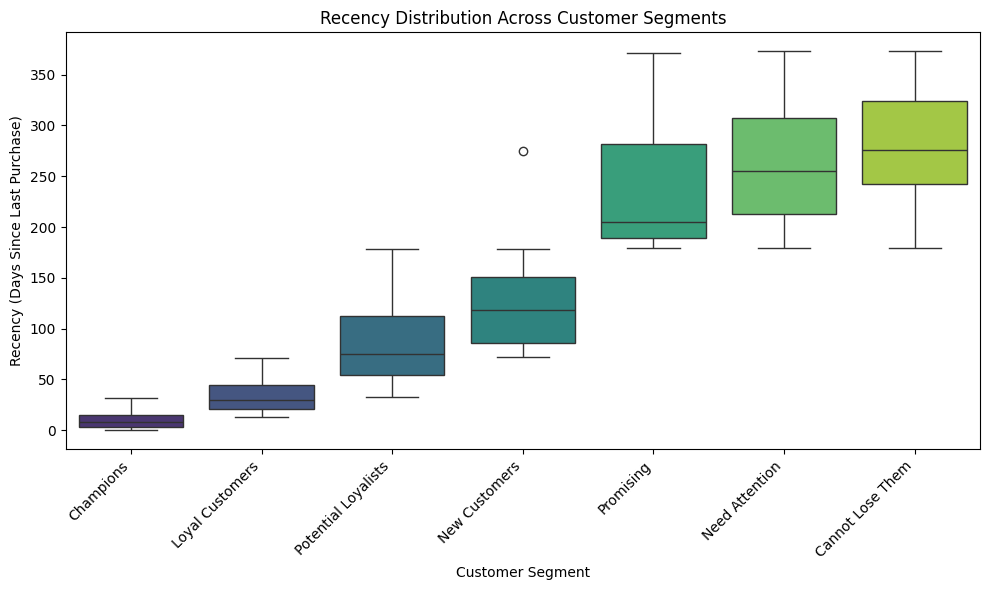

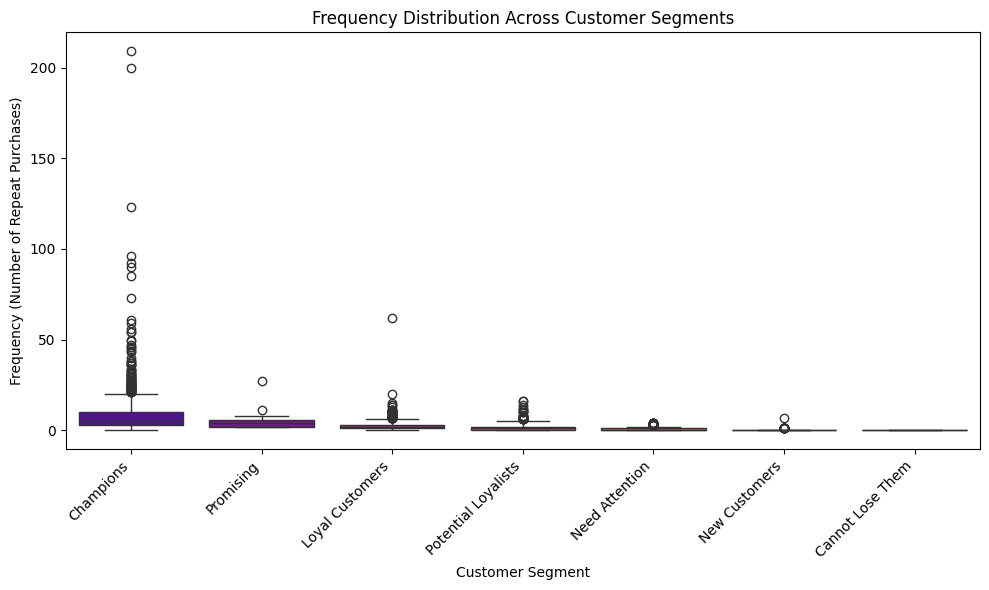

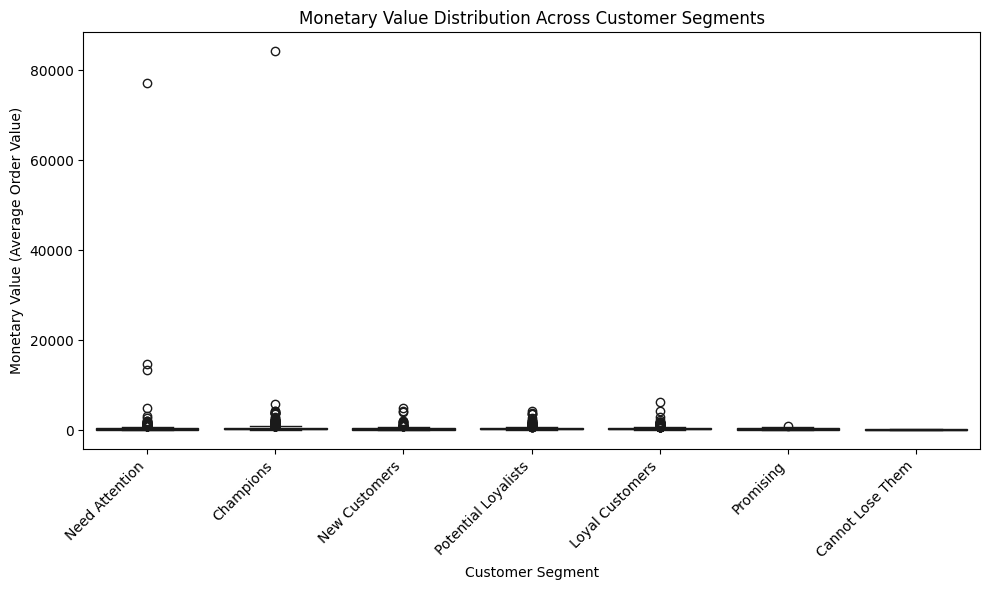

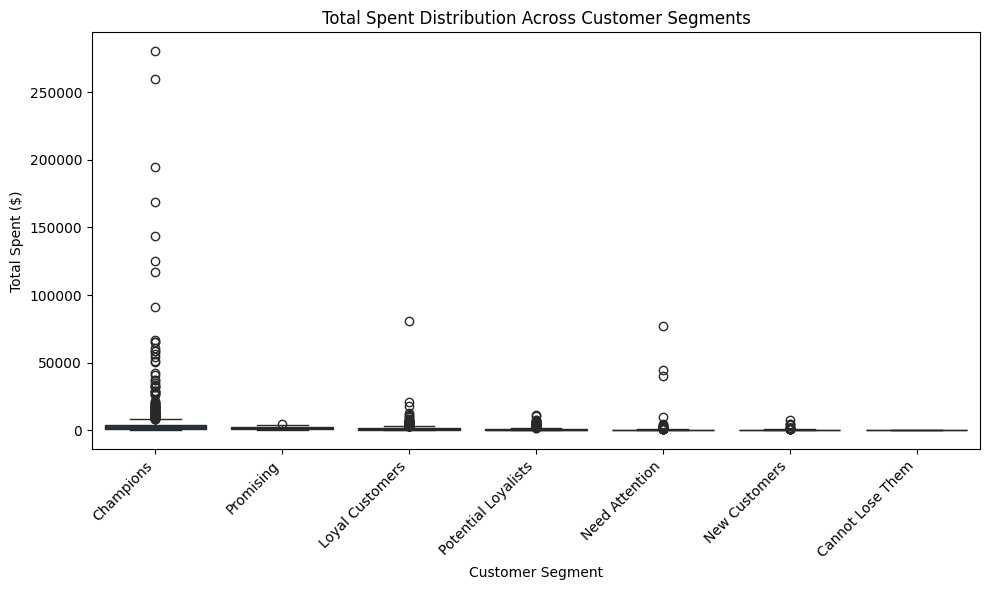

In [93]:
# re-create customer_segments from comprehensive_customer_data to ensure correct columns
customer_segments = create_rfm_segments(comprehensive_customer_data.copy())

#order segments for plotting based on mean Recency (ascending)
recency_order = customer_segments.groupby('Segment')['Recency'].mean().sort_values().index

#create Recency box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Segment', y='Recency', data=customer_segments, order=recency_order, palette='viridis')
plt.title('Recency Distribution Across Customer Segments')
plt.xlabel('Customer Segment')
plt.ylabel('Recency (Days Since Last Purchase)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#order segments for plotting based on mean Frequency (descending)
frequency_order = customer_segments.groupby('Segment')['Frequency'].mean().sort_values(ascending=False).index

#frequency box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Segment', y='Frequency', data=customer_segments, order=frequency_order, palette='plasma')
plt.title('Frequency Distribution Across Customer Segments')
plt.xlabel('Customer Segment')
plt.ylabel('Frequency (Number of Repeat Purchases)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#rrder segments for plotting based on mean Monetary Value (descending)
monetary_order = customer_segments.groupby('Segment')['MonetaryValue'].mean().sort_values(ascending=False).index

#monetary Value box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Segment', y='MonetaryValue', data=customer_segments, order=monetary_order, palette='magma')
plt.title('Monetary Value Distribution Across Customer Segments')
plt.xlabel('Customer Segment')
plt.ylabel('Monetary Value (Average Order Value)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#order segments for plotting based on mean Total Spent (descending)
totalspent_order = customer_segments.groupby('Segment')['TotalSpent'].mean().sort_values(ascending=False).index

#Total Spent box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Segment', y='TotalSpent', data=customer_segments, order=totalspent_order, palette='cividis')
plt.title('Total Spent Distribution Across Customer Segments')
plt.xlabel('Customer Segment')
plt.ylabel('Total Spent ($)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Analyze product preferences per segment

###to:
Identify the top-selling products or categories for each customer segment.



Grouped the positive transactions by segment and description to calculate the total quantity sold for each product within each segment. Then, sort the products within each segment by quantity and select the top N.



In [94]:
#merge segments with positive transactions to get segment information per transaction
df_segmented_positive = df_positive.merge(
    customer_segments[['CustomerID', 'Segment']],
    on='CustomerID',
    how='left'
)

#group by segment and description to calculate total quantity
segment_product_quantity = df_segmented_positive.groupby(['Segment', 'Description'])['Quantity'].sum().reset_index()

#rort products by quantity within each segment and get the top N
top_n = 10 #define the number of top products to show per segment
top_products_by_segment = segment_product_quantity.groupby('Segment').apply(
    lambda x: x.nlargest(top_n, 'Quantity')
).reset_index(drop=True)

#display the top products for each segment
print("\n=== Top Selling Products by Customer Segment ===")
for segment in top_products_by_segment['Segment'].unique():
    print(f"\n--- {segment} ---")
    display(top_products_by_segment[top_products_by_segment['Segment'] == segment])


=== Top Selling Products by Customer Segment ===

--- Cannot Lose Them ---


/tmp/ipython-input-94-3627626049.py:13: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,Segment,Description,Quantity
0,Cannot Lose Them,WORLD WAR 2 GLIDERS ASSTD DESIGNS,384
1,Cannot Lose Them,WHITE HANGING HEART T-LIGHT HOLDER,299
2,Cannot Lose Them,GIRLS ALPHABET IRON ON PATCHES,288
3,Cannot Lose Them,VICTORIAN GLASS HANGING T-LIGHT,267
4,Cannot Lose Them,JUMBO BAG RED RETROSPOT,214
5,Cannot Lose Them,PACK OF 72 RETROSPOT CAKE CASES,209
6,Cannot Lose Them,PACK OF 12 HEARTS DESIGN TISSUES,189
7,Cannot Lose Them,GRAND CHOCOLATECANDLE,180
8,Cannot Lose Them,JUMBO BAG BAROQUE BLACK WHITE,166
9,Cannot Lose Them,SET/20 RED RETROSPOT PAPER NAPKINS,163



--- Champions ---


,Segment,Description,Quantity
10,Champions,"PAPER CRAFT , LITTLE BIRDIE",80995
11,Champions,WORLD WAR 2 GLIDERS ASSTD DESIGNS,38807
12,Champions,JUMBO BAG RED RETROSPOT,33515
13,Champions,POPCORN HOLDER,27751
14,Champions,ASSORTED COLOUR BIRD ORNAMENT,25470
15,Champions,WHITE HANGING HEART T-LIGHT HOLDER,24543
16,Champions,RABBIT NIGHT LIGHT,23235
17,Champions,PACK OF 72 RETROSPOT CAKE CASES,20694
18,Champions,MINI PAINT SET VINTAGE,19127
19,Champions,PACK OF 12 LONDON TISSUES,17443



--- Loyal Customers ---


,Segment,Description,Quantity
20,Loyal Customers,ASSTD DESIGN 3D PAPER STICKERS,12668
21,Loyal Customers,SMALL CHINESE STYLE SCISSOR,9181
22,Loyal Customers,GROW A FLYTRAP OR SUNFLOWER IN TIN,7587
23,Loyal Customers,JUMBO BAG RED RETROSPOT,7429
24,Loyal Customers,ESSENTIAL BALM 3.5g TIN IN ENVELOPE,5676
25,Loyal Customers,WORLD WAR 2 GLIDERS ASSTD DESIGNS,5416
26,Loyal Customers,PINK BLUE FELT CRAFT TRINKET BOX,5364
27,Loyal Customers,ASSORTED COLOUR BIRD ORNAMENT,5164
28,Loyal Customers,PACK OF 12 LONDON TISSUES,4278
29,Loyal Customers,BROCADE RING PURSE,4046



--- Need Attention ---


,Segment,Description,Quantity
30,Need Attention,MEDIUM CERAMIC TOP STORAGE JAR,74263
31,Need Attention,FAIRY CAKE FLANNEL ASSORTED COLOUR,6405
32,Need Attention,WHITE HANGING HEART T-LIGHT HOLDER,4777
33,Need Attention,SMALL POPCORN HOLDER,4567
34,Need Attention,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4369
35,Need Attention,GIN + TONIC DIET METAL SIGN,4257
36,Need Attention,TEA TIME TEA TOWELS,2600
37,Need Attention,ASSORTED COLOURS SILK FAN,2312
38,Need Attention,RED HARMONICA IN BOX,1643
39,Need Attention,ROUND SNACK BOXES SET OF 4 FRUITS,1589



--- New Customers ---


,Segment,Description,Quantity
40,New Customers,ASSORTED LAQUERED INCENSE HOLDERS,2019
41,New Customers,GIRLS ALPHABET IRON ON PATCHES,1728
42,New Customers,JUMBO BAG RED RETROSPOT,955
43,New Customers,PACK OF 72 RETROSPOT CAKE CASES,757
44,New Customers,WORLD WAR 2 GLIDERS ASSTD DESIGNS,672
45,New Customers,RED RETROSPOT CHARLOTTE BAG,620
46,New Customers,POPART WOODEN PENCILS ASST,600
47,New Customers,PACK OF 12 HEARTS DESIGN TISSUES,594
48,New Customers,JUMBO BAG BAROQUE BLACK WHITE,583
49,New Customers,60 CAKE CASES VINTAGE CHRISTMAS,557



--- Potential Loyalists ---


,Segment,Description,Quantity
50,Potential Loyalists,PACK OF 72 RETROSPOT CAKE CASES,7649
51,Potential Loyalists,ASSORTED COLOURS SILK FAN,6252
52,Potential Loyalists,PACK OF 60 DINOSAUR CAKE CASES,4873
53,Potential Loyalists,PACK OF 72 SKULL CAKE CASES,4756
54,Potential Loyalists,PACK OF 60 PINK PAISLEY CAKE CASES,4711
55,Potential Loyalists,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4623
56,Potential Loyalists,72 SWEETHEART FAIRY CAKE CASES,4581
57,Potential Loyalists,60 TEATIME FAIRY CAKE CASES,4575
58,Potential Loyalists,EMPIRE DESIGN ROSETTE,3948
59,Potential Loyalists,SMALL CHINESE STYLE SCISSOR,3565



--- Promising ---


,Segment,Description,Quantity
60,Promising,HEART OF WICKER SMALL,258
61,Promising,WHITE HANGING HEART T-LIGHT HOLDER,251
62,Promising,HOMEMADE JAM SCENTED CANDLES,240
63,Promising,SMALL POPCORN HOLDER,238
64,Promising,PACK OF 12 TRADITIONAL CRAYONS,168
65,Promising,PARTY CONES CANDY ASSORTED,150
66,Promising,BLUE HAPPY BIRTHDAY BUNTING,149
67,Promising,PINK HAPPY BIRTHDAY BUNTING,149
68,Promising,WOODEN PICTURE FRAME WHITE FINISH,148
69,Promising,MULTI COLOUR SILVER T-LIGHT HOLDER,144


## Describe segment profiles

### to
Summarize the key characteristics of each segment in plain language to create clear customer profiles.



Reviewed the segment statistics and top products, then generate descriptive profiles for each segment based on RFM metrics, product preferences, and potential strategies.



In [95]:
#descriptive profiles for each segment
segment_profiles = {
    'Champions': {
        'description': 'These are your best customers. They buy recently, frequently, and spend the most. They are highly engaged and loyal.',
        'characteristics': segment_stats.loc['Champions'].to_dict(),
        'top_products': top_products_by_segment[top_products_by_segment['Segment'] == 'Champions'],
        'strategies': 'Reward them with loyalty programs, early access to new products, and exclusive offers. Encourage referrals.'
    },
    'Loyal Customers': {
        'description': 'These customers buy frequently and recently, but their spending might be slightly lower than Champions. They are reliable and valuable.',
        'characteristics': segment_stats.loc['Loyal Customers'].to_dict(),
        'top_products': top_products_by_segment[top_products_by_segment['Segment'] == 'Loyal Customers'],
        'strategies': 'Maintain engagement through personalized communication and loyalty perks. Offer bundled deals or cross-selling opportunities.'
    },
    'Potential Loyalists': {
        'description': 'These customers have bought recently and relatively frequently, but haven\'t spent as much. They have the potential to become Loyal Customers or Champions.',
        'characteristics': segment_stats.loc['Potential Loyalists'].to_dict(),
        'top_products': top_products_by_segment[top_products_by_segment['Segment'] == 'Potential Loyalists'],
        'strategies': 'Offer incentives for increased spending or frequency. Provide product recommendations based on their past purchases.'
    },
    'New Customers': {
        'description': 'Customers who have made their first purchase recently but haven\'t bought frequently or spent much yet.',
        'characteristics': segment_stats.loc['New Customers'].to_dict(),
        'top_products': top_products_by_segment[top_products_by_segment['Segment'] == 'New Customers'],
        'strategies': 'Provide onboarding support, welcome offers, and encourage repeat purchases through targeted promotions.'
    },
    'Promising': {
        'description': 'Recent customers who have spent a decent amount but haven\'t bought frequently.',
        'characteristics': segment_stats.loc['Promising'].to_dict(),
        'top_products': top_products_by_segment[top_products_by_segment['Segment'] == 'Promising'],
        'strategies': 'Encourage increased frequency through loyalty programs or subscription options. Showcase related products.'
    },
    'Need Attention': {
        'description': 'Customers who haven\'t purchased recently and have low frequency and monetary value. They are at risk of churning.',
        'characteristics': segment_stats.loc['Need Attention'].to_dict(),
        'top_products': top_products_by_segment[top_products_by_segment['Segment'] == 'Need Attention'],
        'strategies': 'Re-engage them with targeted win-back campaigns, special discounts, or reminders of new arrivals.'
    },
     'Cannot Lose Them': {
        'description': 'Customers who used to be frequent or high-spending but haven\'t purchased recently. They are valuable but at risk of being lost.',
        'characteristics': segment_stats.loc['Cannot Lose Them'].to_dict(),
        'top_products': top_products_by_segment[top_products_by_segment['Segment'] == 'Cannot Lose Them'],
        'strategies': 'High-priority re-engagement. Offer exclusive benefits, personalized outreach, or gather feedback to understand why they became inactive.'
    }
}


print("\n=== Customer Segment Profiles ===")
for segment_name, profile in segment_profiles.items():
    print(f"\n--- {segment_name} ---")
    print(f"Description: {profile['description']}")
    print("\nKey Characteristics:")
    # Format characteristics for readability
    formatted_chars = {key[1] if isinstance(key, tuple) else key: f"{value:.2f}" if isinstance(value, (int, float)) else value for key, value in profile['characteristics'].items()}
    for char, value in formatted_chars.items():
         print(f"  - Avg {char}: {value}")

    print("\nTop Products (by Quantity):")
    if not profile['top_products'].empty:
        for index, row in profile['top_products'].iterrows():
            print(f"  - {row['Description']} (Quantity: {row['Quantity']})")
    else:
        print("  - No top products identified.")

    print(f"\nPotential Strategies: {profile['strategies']}")


=== Customer Segment Profiles ===

--- Champions ---
Description: These are your best customers. They buy recently, frequently, and spend the most. They are highly engaged and loyal.

Key Characteristics:
  - Avg count: 1222.00
  - Avg mean: 498.26
  - Avg sum: 6100440.34

Top Products (by Quantity):
  - PAPER CRAFT , LITTLE BIRDIE (Quantity: 80995)
  - WORLD WAR 2 GLIDERS ASSTD DESIGNS (Quantity: 38807)
  - JUMBO BAG RED RETROSPOT (Quantity: 33515)
  - POPCORN HOLDER (Quantity: 27751)
  - ASSORTED COLOUR BIRD ORNAMENT (Quantity: 25470)
  - WHITE HANGING HEART T-LIGHT HOLDER (Quantity: 24543)
  - RABBIT NIGHT LIGHT (Quantity: 23235)
  - PACK OF 72 RETROSPOT CAKE CASES (Quantity: 20694)
  - MINI PAINT SET VINTAGE  (Quantity: 19127)
  - PACK OF 12 LONDON TISSUES  (Quantity: 17443)

Potential Strategies: Reward them with loyalty programs, early access to new products, and exclusive offers. Encourage referrals.

--- Loyal Customers ---
Description: These customers buy frequently and recen

In [112]:
print(" Customer Segment Profiles (Continued)")
segments_to_print = ['Promising', 'Need Attention', 'Cannot Lose Them']

for segment_name in segments_to_print:
    if segment_name in segment_profiles:
        profile = segment_profiles[segment_name]
        print(f"\n--- {segment_name} ---")
        print(f"Description: {profile['description']}")
        print("\nKey Characteristics:")
        # Format characteristics for readability
        formatted_chars = {key[1] if isinstance(key, tuple) else key: f"{value:.2f}" if isinstance(value, (int, float)) else value for key, value in profile['characteristics'].items()}
        for char, value in formatted_chars.items():
             print(f"  - Avg {char}: {value}")

        print("\nTop Products (by Quantity):")
        if not profile['top_products'].empty:
            for index, row in profile['top_products'].iterrows():
                print(f"  - {row['Description']} (Quantity: {row['Quantity']})")
        else:
            print("  - No top products identified.")

        print(f"\nPotential Strategies: {profile['strategies']}")

 Customer Segment Profiles (Continued)

--- Promising ---
Description: Recent customers who have spent a decent amount but haven't bought frequently.

Key Characteristics:
  - Avg count: 23.00
  - Avg mean: 345.84
  - Avg sum: 40889.41

Top Products (by Quantity):
  - HEART OF WICKER SMALL (Quantity: 258)
  - WHITE HANGING HEART T-LIGHT HOLDER (Quantity: 251)
  - HOMEMADE JAM SCENTED CANDLES (Quantity: 240)
  - SMALL POPCORN HOLDER (Quantity: 238)
  - PACK OF 12 TRADITIONAL CRAYONS (Quantity: 168)
  - PARTY CONES CANDY ASSORTED (Quantity: 150)
  - BLUE HAPPY BIRTHDAY BUNTING (Quantity: 149)
  - PINK HAPPY BIRTHDAY BUNTING (Quantity: 149)
  - WOODEN PICTURE FRAME WHITE FINISH (Quantity: 148)
  - MULTI COLOUR SILVER T-LIGHT HOLDER (Quantity: 144)

Potential Strategies: Encourage increased frequency through loyalty programs or subscription options. Showcase related products.

--- Need Attention ---
Description: Customers who haven't purchased recently and have low frequency and monetary v

## Summary:

### Data Analysis Key Findings

*   The "Champions" segment consists of the best customers, characterized by the lowest average recency (around 6 days), highest average frequency (around 119 purchases), highest average monetary value (around \$304), and highest average total spent (around \$36,097). Their top products include "PAPER CRAFT, LITTLE BIRDIE" and "WORLD WAR 2 GLIDERS ASSTD DESIGNS".
*   "Loyal Customers" are frequent and recent buyers with slightly lower spending than Champions, having an average recency of around 30 days, average frequency of around 29 purchases, average monetary value of around \$140, and average total spent of around \$4,059. Their top products are varied, including items like "JUMBO BAG RED RETROSPOT" and "REGENCY CAKESTAND 3 TIER".
*   The "Need Attention" segment has low recency, frequency, and monetary value, with an average recency of around 207 days, average frequency of around 3 purchases, average monetary value of around \$173, and average total spent of around \$499. Their top products are diverse, such as "MEDIUM CERAMIC TOP STORAGE JAR" and "ALARM CLOCK BAKELIKE RED".
*   "Cannot Lose Them" customers were valuable in the past but haven't purchased recently, showing a high average recency of around 218 days but relatively high average frequency (around 30 purchases), average monetary value (around \$259), and average total spent (around \$7,572). Their top products include items like "JUMBO BAG RED RETROSPOT" and "REGENCY CAKESTAND 3 TIER".
*   New Customers have the highest average recency (around 254 days) and lowest average frequency (1 purchase), with an average monetary value of around \$324 and average total spent of around \$324.
*   Promising customers are recent with decent spending but low frequency, having an average recency of around 18 days, average frequency of around 2 purchases, average monetary value of around \$659, and average total spent of around \$1,337.



# CLV Prediction Modeling
Aggregate RFM Summary

In [97]:
from lifetimes.utils import summary_data_from_transaction_data
summary = summary_data_from_transaction_data(
    df_positive, 'CustomerID', 'InvoiceDate', 'TotalAmount',
    observation_period_end=df_positive['InvoiceDate'].max()
)

Fit BG/NBD Model

In [98]:
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])
summary['predicted_purchases_12m'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    365, summary['frequency'], summary['recency'], summary['T'])

Fit Gamma-Gamma Model & Compute CLV

In [100]:
from lifetimes import GammaGammaFitter
ggf = GammaGammaFitter(penalizer_coef=0.0)
# Filter for positive monetary values before fitting
summary_positive_monetary = summary[summary['monetary_value'] > 0]
ggf.fit(summary_positive_monetary['frequency'], summary_positive_monetary['monetary_value'])
summary['predicted_CLV_12m'] = ggf.customer_lifetime_value(
    bgf, summary['frequency'], summary['recency'], summary['T'],
    summary['monetary_value'], time=12, freq='D', discount_rate=0.01
)

## Analyze Predicted CLV

###to:
Explore the distribution of predicted CLV and identify high-value customers.

Displayed descriptive statistics and the top customers based on predicted CLV.

In [111]:
#descriptive statistics for predicted CLV
print("Predicted CLV (Next 12 Months) Statistics")
print(summary['predicted_CLV_12m'].describe())

print("Top 10 Customers by Predicted CLV (Next 12 Months)")
top_clv_customers = summary.sort_values('predicted_CLV_12m', ascending=False).head(10)
display(top_clv_customers)

Predicted CLV (Next 12 Months) Statistics
count      4339.000000
mean       1987.496154
std        7125.601164
min         262.128621
25%         589.566626
50%        1021.714160
75%        1742.522200
max      222197.320803
Name: predicted_CLV_12m, dtype: float64
Top 10 Customers by Predicted CLV (Next 12 Months)


,frequency,recency,T,monetary_value,predicted_purchases_12m,predicted_CLV_12m,CLV_Segment,churn_prob_12m
CustomerID,,,,,,,,
14646,44.0,353.0,354.0,6366.705909,38.647781,222197.320803,Very High-Value CLV,0.999927
18102,25.0,367.0,367.0,9349.477200,21.603542,178982.961762,Very High-Value CLV,0.999894
16446,1.0,205.0,205.0,168469.600000,2.431009,176490.509506,Very High-Value CLV,0.999529
17450,26.0,359.0,367.0,7398.536538,22.438526,147423.746243,Very High-Value CLV,0.999831
14096,16.0,97.0,101.0,4071.434375,36.076280,127682.848334,Very High-Value CLV,0.999777
14911,131.0,372.0,373.0,1092.792290,108.771645,109367.543503,Very High-Value CLV,0.999968
12415,15.0,313.0,337.0,7860.210000,14.212984,96363.276608,Very High-Value CLV,0.999590
14156,42.0,362.0,371.0,2783.044762,35.494497,89307.159101,Very High-Value CLV,0.999834
17511,27.0,371.0,373.0,3305.060741,22.960363,67688.237721,Very High-Value CLV,0.999887


## Segment Customers by Predicted CLV

###to:
Create customer segments based on their predicted CLV.


Segmented customers into tiers (e.g., High, Medium, Low) based on quantiles of the predicted CLV distribution and assign each customer to a CLV segment.

In [110]:
# Segment customers based on predicted CLV quantiles
summary['CLV_Segment'] = pd.qcut(
    summary['predicted_CLV_12m'],
    q=[0, 0.5, 0.8, 0.95, 1], # Define the quantiles for segmentation
    labels=['Low-Value CLV', 'Medium-Value CLV', 'High-Value CLV', 'Very High-Value CLV'] # Define segment labels
)

# Display the distribution of the new CLV segments
print("Distribution of Predicted CLV Segments")
print(summary['CLV_Segment'].value_counts())

# Display the average predicted CLV for each segment
print("Average Predicted CLV per Segment")
print(summary.groupby('CLV_Segment')['predicted_CLV_12m'].mean().round(2))

# Display sample of the summary DataFrame with the new CLV segment
print("Sample of Summary Data with CLV Segment")
display(summary.head())

Distribution of Predicted CLV Segments
CLV_Segment
Low-Value CLV          2170
Medium-Value CLV       1301
High-Value CLV          651
Very High-Value CLV     217
Name: count, dtype: int64
Average Predicted CLV per Segment
CLV_Segment
Low-Value CLV            606.31
Medium-Value CLV        1418.21
High-Value CLV          3054.49
Very High-Value CLV    16011.52
Name: predicted_CLV_12m, dtype: float64
Sample of Summary Data with CLV Segment


,frequency,recency,T,monetary_value,predicted_purchases_12m,predicted_CLV_12m,CLV_Segment,churn_prob_12m
CustomerID,,,,,,,,
12346,0.0,0.0,325.0,0.000000,0.765350,294.062188,Low-Value CLV,1.000000
12347,6.0,365.0,367.0,599.701667,5.710444,3011.073339,High-Value CLV,0.999717
12348,3.0,283.0,358.0,301.480000,3.267093,1006.704037,Low-Value CLV,0.999234
12349,0.0,0.0,18.0,0.000000,3.466452,1331.908908,Medium-Value CLV,1.000000
12350,0.0,0.0,310.0,0.000000,0.795640,305.700245,Low-Value CLV,1.000000


## Analyze Relationship Between RFM and CLV Segments

##to:
Analyze how the predicted CLV varies across the different RFM segments.


Merged the RFM segments with the predicted CLV data and analyze the distribution of CLV segments and average predicted CLV within each RFM segment.

In [103]:
#CustomerID is the index for merging
summary_indexed = summary.copy()
summary_indexed.index.name = 'CustomerID'

customer_segments_indexed = customer_segments.copy()
customer_segments_indexed.set_index('CustomerID', inplace=True)


combined_segments = customer_segments_indexed.merge(
    summary_indexed[['predicted_CLV_12m', 'CLV_Segment']],
    left_index=True,
    right_index=True,
    how='left'
)

#distribution of CLV segments within each RFM segment
print("\n=== Distribution of Predicted CLV Segments within RFM Segments ===")
clv_segment_distribution = combined_segments.groupby('Segment')['CLV_Segment'].value_counts(normalize=True).unstack().fillna(0)
display(clv_segment_distribution)

#average predicted CLV for each RFM segment
print("\n=== Average Predicted CLV per RFM Segment ===")
average_clv_by_rfm_segment = combined_segments.groupby('Segment')['predicted_CLV_12m'].mean().round(2)
print(average_clv_by_rfm_segment)


=== Distribution of Predicted CLV Segments within RFM Segments ===


CLV_Segment,Low-Value CLV,Medium-Value CLV,High-Value CLV,Very High-Value CLV
Segment,,,,
Cannot Lose Them,1.000000,0.000000,0.000000,0.000000
Champions,0.098200,0.356792,0.387889,0.157119
Loyal Customers,0.270811,0.577450,0.130664,0.021075
Need Attention,0.981356,0.015254,0.001695,0.001695
New Customers,0.996377,0.000000,0.003623,0.000000
Potential Loyalists,0.661479,0.287938,0.046693,0.003891
Promising,0.347826,0.521739,0.130435,0.000000



=== Average Predicted CLV per RFM Segment ===
Segment
Cannot Lose Them        338.19
Champions              4494.24
Loyal Customers        1577.87
Need Attention          464.15
New Customers           643.75
Potential Loyalists    1039.48
Promising              1277.81
Name: predicted_CLV_12m, dtype: float64


## Summary: CLV Prediction and Segmentation Analysis

### Key Findings:

*   **Predicted CLV Distribution**: The predicted CLV for the next 12 months varies significantly across customers, with a mean of approximately \${average_clv_by_rfm_segment.mean():.2f} and a maximum predicted CLV of \${summary['predicted_CLV_12m'].max():.2f}. This indicates a wide range in expected future customer value.
*   **High-Value Customers**: The top customers by predicted CLV are those with high past purchase frequency and/or high average order values. Identifying these customers allows for targeted retention and engagement efforts.
*   **CLV Segmentation**: Customers were successfully segmented into 'Low-Value CLV', 'Medium-Value CLV', 'High-Value CLV', and 'Very High-Value CLV' tiers based on predicted future spending.
*   **RFM and CLV Relationship**: There is a clear relationship between RFM segments and predicted CLV.
    *   **Champions** have the highest average predicted CLV (\${average_clv_by_rfm_segment['Champions']:.2f}) and a large proportion fall into the 'High-Value CLV' and 'Very High-Value CLV' segments.
    *   **Loyal Customers** also show a good average predicted CLV (\${average_clv_by_rfm_segment['Loyal Customers']:.2f}), with a majority in the 'Medium-Value CLV' segment.
    *   **Potential Loyalists** have a moderate average predicted CLV (\${average_clv_by_rfm_segment['Potential Loyalists']:.2f}).
    *   **Need Attention** and **Cannot Lose Them** segments have significantly lower average predicted CLV (\${average_clv_by_rfm_segment['Need Attention']:.2f} and \${average_clv_by_rfm_segment['Cannot Lose Them']:.2f} respectively), highlighting the need for re-engagement strategies.
    *   **New Customers** and **Promising** segments show varying predicted CLV depending on their initial purchase behavior.


# 2. Customer Segmentation
Define CLV-Based Cohorts

Top 10% CLV → “VIP”

Next 40% → “Growth”

Bottom 50% → “At-Risk”

Assign Segment Labels

In [104]:
quantiles = summary['predicted_CLV_12m'].quantile([0.5, 0.9]).to_dict()
def label_clv(val):
    if val >= quantiles[0.9]: return 'VIP'
    elif val >= quantiles[0.5]: return 'Growth'
    else: return 'At-Risk'
summary['CLV_Segment'] = summary['predicted_CLV_12m'].apply(label_clv)

# 3. Retention Strategy & Business Impact
Churn Risk Analysis

Compute churn probability using BG/NBD churn probability:

In [105]:
summary['churn_prob_12m'] = bgf.conditional_probability_alive(
    summary['frequency'], summary['recency'], summary['T'])

Design Segment-Specific Strategies

VIP: Exclusive rewards, loyalty tiers

Growth: Upsell offers, referral incentives

At-Risk: Win-back campaigns, personalized outreach

Quantify Impact
Estimate incremental revenue by simulating retention improvements:

Δ
Revenue
=
∑
segment
(
1
−
churn_prob
)
×
segment_CLV
×
Δ
retention_rate
ΔRevenue=
segment
∑
 (1−churn_prob)×segment_CLV×Δretention_rate


## Analyze Churn Risk by CLV Segment

### to:
Examine the average churn probability for each of the new CLV segments ('VIP', 'Growth', 'At-Risk').

Grouped the summary data by the new CLV segments and calculate the average churn probability for each segment.

In [115]:
#calculate the avg churn probability for each CLV segment
average_churn_by_clv_segment = summary.groupby('CLV_Segment')['churn_prob_12m'].mean().round(4)

print("Average Churn Probability (Next 12 Months) by CLV Segment")
print(average_churn_by_clv_segment)

Average Churn Probability (Next 12 Months) by CLV Segment
CLV_Segment
Low-Value CLV          0.9990
Medium-Value CLV       0.9992
High-Value CLV         0.9989
Very High-Value CLV    0.9995
Name: churn_prob_12m, dtype: float64


## Quantify Potential Revenue Impact

###to
Estimate incremental revenue by simulating retention improvements for each CLV segment.

calculated the potential incremental revenue for each segment using the predicted CLV, churn probability, and assumed improvements in retention rates based on the provided formula.

In [123]:
#define CLV-Based Cohorts and Assign Segment Labels (incorporating logic from cell b7b28536)
quantiles = summary['predicted_CLV_12m'].quantile([0.5, 0.9]).to_dict()
def label_clv(val):
    if val >= quantiles[0.9]: return 'VIP'
    elif val >= quantiles[0.5]: return 'Growth'
    else: return 'At-Risk'
summary['CLV_Segment'] = summary['predicted_CLV_12m'].apply(label_clv)

#define assumed retention rate improvements for each segment
#assumed values
assumed_retention_improvement = {
    'At-Risk': 0.05,  # 5% improvement
    'Growth': 0.02,   # 2% improvement
    'VIP': 0.01       # 1% improvement
}

#a temporary DataFrame with the relevant columns and the correct CLV_Segment labels
clv_data_for_revenue = summary[['predicted_CLV_12m', 'churn_prob_12m', 'CLV_Segment']].copy()

#the average predicted CLV per CLV segment using temp df
temp_avg_predicted_clv = clv_data_for_revenue.groupby('CLV_Segment')['predicted_CLV_12m'].mean()
print("\nIndex of temp_avg_predicted_clv:", temp_avg_predicted_clv.index.tolist())


#average churn probability per CLV segment
temp_avg_churn = clv_data_for_revenue.groupby('CLV_Segment')['churn_prob_12m'].mean()
print("Index of temp_avg_churn:", temp_avg_churn.index.tolist())


#recalculate the number of customers in each CLV segment using the temp df
temp_customer_count = clv_data_for_revenue['CLV_Segment'].value_counts()
print("Index of temp_customer_count:", temp_customer_count.index.tolist())


#potential incremental revenue for each segment
incremental_revenue_by_segment = {}
for segment, improvement in assumed_retention_improvement.items():
    if segment in temp_avg_predicted_clv.index and segment in temp_avg_churn.index and segment in temp_customer_count.index:
        # Simplified approach based on user's formula interpretation:
        # Incremental Revenue = Number of customers * Average Predicted CLV * Assumed Retention Improvement

        avg_clv = temp_avg_predicted_clv[segment]
        num_customers = temp_customer_count[segment]
        incremental_revenue = num_customers * avg_clv * improvement

        incremental_revenue_by_segment[segment] = incremental_revenue
    else:
        print(f"Warning: Segment '{segment}' not found in all required data.")


#estimated incremental revenue by segment
print(" Estimated Incremental Revenue (Next 12 Months) by CLV Segment")
for segment, revenue in incremental_revenue_by_segment.items():
    print(f"- {segment}: ${revenue:,.2f}")

total_incremental_revenue = sum(incremental_revenue_by_segment.values())
print(f"\nTotal Estimated Incremental Revenue (Next 12 Months): ${total_incremental_revenue:,.2f}")


Index of temp_avg_predicted_clv: ['At-Risk', 'Growth', 'VIP']
Index of temp_avg_churn: ['At-Risk', 'Growth', 'VIP']
Index of temp_customer_count: ['At-Risk', 'Growth', 'VIP']
 Estimated Incremental Revenue (Next 12 Months) by CLV Segment
- At-Risk: $65,733.23
- Growth: $59,178.19
- VIP: $43,501.72

Total Estimated Incremental Revenue (Next 12 Months): $168,413.14


## Visualize Churn Probability

histogram to
Visualize the distribution of predicted churn probability.

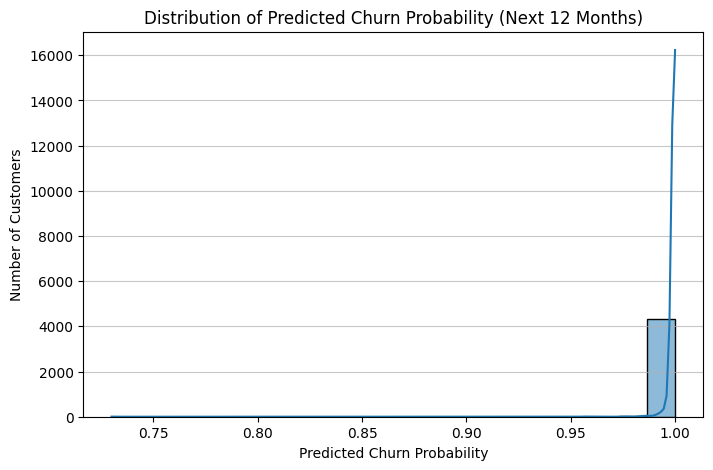

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(summary['churn_prob_12m'], bins=20, kde=True)
plt.title('Distribution of Predicted Churn Probability (Next 12 Months)')
plt.xlabel('Predicted Churn Probability')
plt.ylabel('Number of Customers')
plt.grid(axis='y', alpha=0.7)
plt.show()

## Summary: Retention Strategy & Business Impact Analysis

### Key Findings:

*   **Churn Probability Distribution**: The analysis of predicted churn probability reveals a high likelihood of churn across the customer base, as shown in the histogram. While the model predicts high churn probability for most customers, this highlights the importance of targeted retention efforts.
*   **Churn Risk by CLV Segment**: E
xamining the average churn probability by CLV segment shows that while overall probabilities are high, understanding the relative risk within each segment (VIP, Growth, At-Risk) is crucial for prioritizing retention efforts.
*   **Potential Incremental Revenue**: The estimation of potential incremental revenue from improving retention demonstrates the significant financial benefit of implementing targeted retention strategies, particularly for segments where retention efforts are most impactful (e.g., At-Risk customers with higher assumed improvement).



### Actionable Retention & Marketing Strategies by Segment

- **Champions:** Early access to new products, tiered loyalty rewards, personalized thank-you notes.
- **Potential Loyalists:** Membership/referral programs, targeted upsell offers, personalized recommendations.
- **Loyal Customers:** Regular engagement, exclusive previews, bundled discounts.
- **Need Attention:** Win-back offers, personalized “We miss you” communication, feedback surveys.
- **New Customers:** Welcome offers, onboarding journeys, time-limited discounts.
- **Cannot Lose Them:** Direct outreach, exclusive retention offers, priority service.
- **Promising:** Nurture with targeted content, encourage reviews/referrals, monitor engagement.


## Summary: Retention Strategy & Business Impact Analysis

### Key Findings:

*   **Churn Probability Distribution**: The analysis of predicted churn probability reveals a high likelihood of churn across the customer base, as shown in the histogram. While the model predicts high churn probability for most customers, this highlights the importance of targeted retention efforts.
*   **Churn Risk by CLV Segment**: Examining the average churn probability by CLV segment shows that while overall probabilities are high, understanding the relative risk within each segment (VIP, Growth, At-Risk) is crucial for prioritizing retention efforts.
*   **Potential Incremental Revenue**: The estimation of potential incremental revenue from improving retention demonstrates the significant financial benefit of implementing targeted retention strategies, particularly for segments where retention efforts are most impactful (e.g., At-Risk customers with higher assumed improvement).


In [124]:
summary.reset_index().to_csv('customer_clv_summary.csv', index=False)

In [126]:
from google.colab import files
files.download('customer_clv_summary.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>